In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VAR

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

!pip install scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd

from google.colab import drive




In [3]:
drive.mount('/content/drive')
path_to_csv = '/content/drive/My Drive/Colab Notebooks/ML/PSO.csv'

df = pd.read_csv(path_to_csv, sep = ",",decimal =".")


Mounted at /content/drive


In [4]:
df.drop('Symbol', axis=1, inplace=True)
df.drop('Low', axis=1, inplace=True)
#df['Date'] = pd.to_datetime(df.Period , format = '%d.%m.%Y')
df['Date'] = pd.to_datetime(df.Date , format = '%d-%b-%Y')
df = df.set_index('Date')

In [5]:
#Блок предбоработки временного ряда
df.head()

,Open,High,Close,Volume
Date,,,,
2003-01-01,213.5,215.10,208.00,29005800
2003-01-02,208.0,217.00,215.65,48945500
2003-01-03,218.0,219.50,219.40,32286100
2003-01-06,219.0,226.25,225.30,51049100
2003-01-07,227.0,232.95,228.95,53225400


In [6]:
df.describe()

,Open,High,Close,Volume
count,4065.000000,4065.000000,4065.000000,4.065000e+03
mean,315.900910,319.737875,315.402625,3.346508e+06
std,78.028117,78.855480,77.848331,6.595363e+06
min,94.000000,100.000000,96.000000,1.000000e+02
25%,259.400000,261.500000,258.840000,4.603000e+05
50%,310.000000,314.300000,309.340000,1.106500e+06
75%,375.000000,380.000000,375.000000,2.713600e+06
max,537.000000,544.900000,539.700000,6.570180e+07


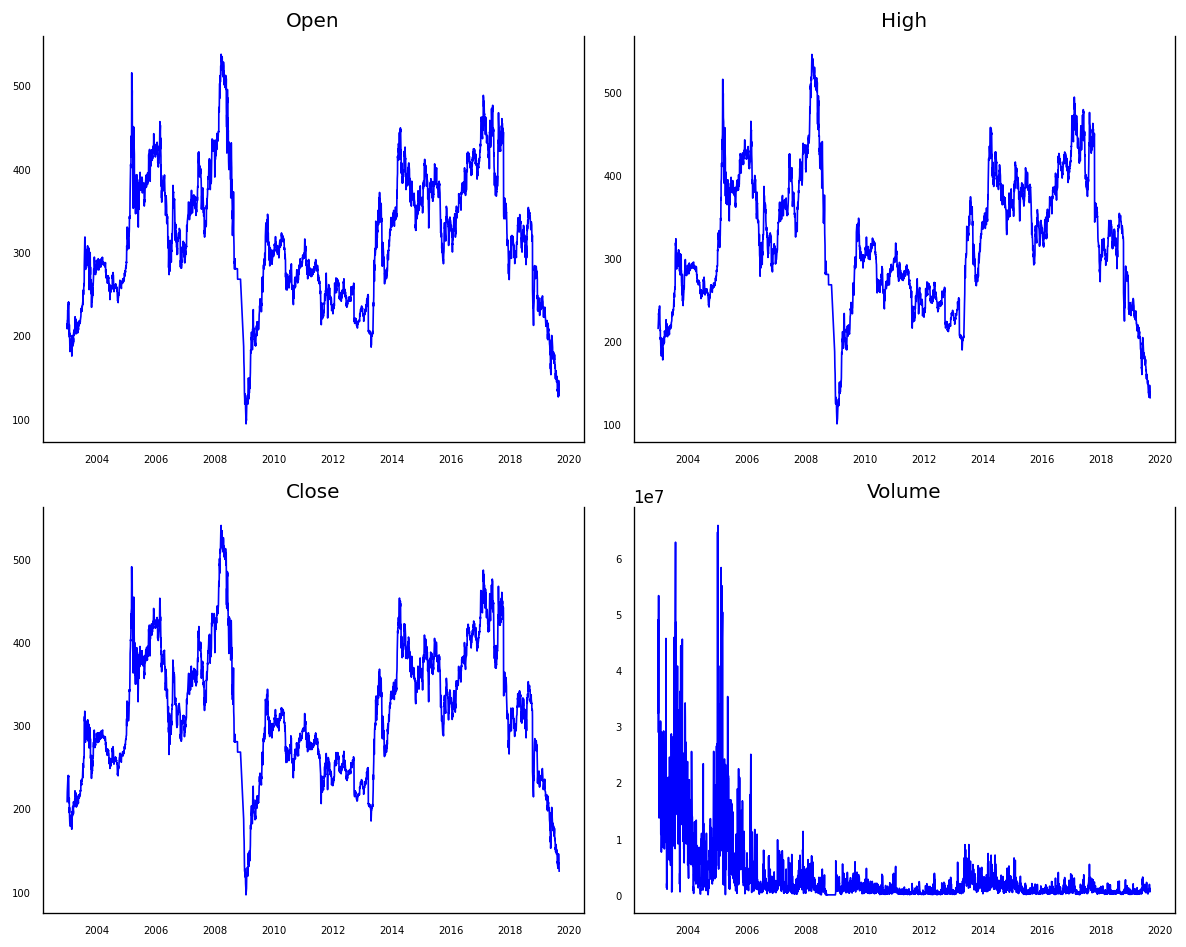

In [9]:
#Смотрим на графики считанных временных рядов.

fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    if i < 4 :
        data = df[df.columns[i]]
        ax.plot(data, color='blue', linewidth=1)
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
plt.tight_layout()

In [10]:
#Проверка на пропуски
skips = df.isnull().sum()
skips

Open      0
High      0
Close     0
Volume    0
dtype: int64

In [11]:
df.shape

(4065, 4)

In [ ]:
#Заполнение пропущенных значений ближайшими соседними наблюдениями
#df.ffill(inplace=True)

In [12]:
#Проверяем наши ряды на стационарность.

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 9), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [13]:
train = df[:int(0.8 * (len(data)))]
test = df[int(0.8 * (len(data))):]

In [14]:
print(train.shape)

(3252, 4)


In [15]:
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1155
 No. Lags Chosen       = 24
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.025424599. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9764
 No. Lags Chosen       = 14
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.037156677. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

In [16]:
# если нестационарный, то удаляем тренд (помните дифференцирование ?) и опять проверяеми
# 1st difference
#df_differenced = train.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
#for name, column in df_differenced.items():
#    adfuller_test(column, name=column.name)
#    print('\n')

In [17]:
#VAR
#Для VAR модели важен порядок - число, которое характеризует набор предыдущих значений,
#которые модель использует для предсказаний следующих значений.

#Подберём его с помощью специального метода и выбирем то,
#где лучше всего метрики AIC (Akaike Information Criterion),
#BIC (Bayesian Information Criterion), FPE (Final Prediction Error) и HQC (Hannan-Quinn Criterion).
model = VAR(train)
x = model.select_order(maxlags=100)
x.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,45.54,45.54,5.971e+19,45.54
1,37.97,38.01,3.104e+16,37.99
2,37.81,37.88,2.630e+16,37.83
3,37.72,37.82*,2.413e+16,37.76
4,37.71,37.84,2.389e+16,37.76
5,37.70,37.86,2.366e+16,37.76
6,37.68,37.87,2.302e+16,37.74
7,37.66,37.88,2.266e+16,37.74*
8,37.66,37.91,2.267e+16,37.75
9,37.65,37.93,2.242e+16,37.75


In [18]:
#Выбираем наилучшее число - 18 и обучаем модель.

model_fitted = model.fit(18)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Mar, 2024
Time:                     22:03:28
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    38.1976
Nobs:                     3234.00    HQIC:                   37.8453
Log likelihood:          -78941.0    FPE:                2.24157e+16
AIC:                      37.6485    Det(Omega_mle):     2.05011e+16
--------------------------------------------------------------------
Results for equation Open
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.381654         0.263562            1.448           0.148
L1.Open            0.039889         0.022891            1.743           0.081
L1.High           -0.012565         0.027199           -0.462           0

In [19]:
#Готовим данные для проверки предсказаний.

def create_dataset(test, in_seq, for_len, step):
    testX = []
    testY = []
    for i in range(0, len(test) - for_len - in_seq, step):
        testX.append(test[i:(i + in_seq)].to_numpy())
        testY.append(test[(i + in_seq):(i + in_seq + for_len)].to_numpy())
    return testX, testY


In [20]:
X_test, Y_test = create_dataset(test, 18, 1, 1)
X_train, Y_train = create_dataset(train, 18, 1, 1)

In [21]:
predictions = []
for x in X_test:
    predictions += [model_fitted.forecast(y=x,steps=1)]
predictions = np.array(predictions)
Y_test = np.array(Y_test)
print(predictions.shape)

(794, 1, 4)


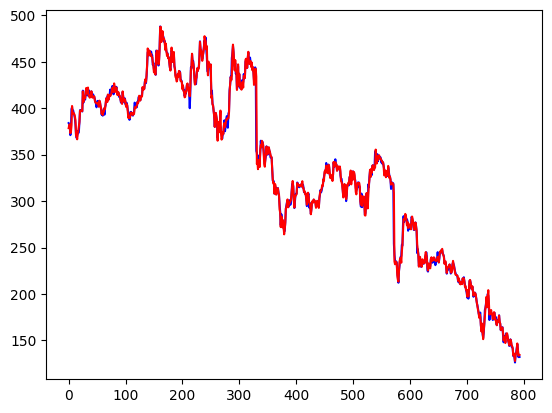

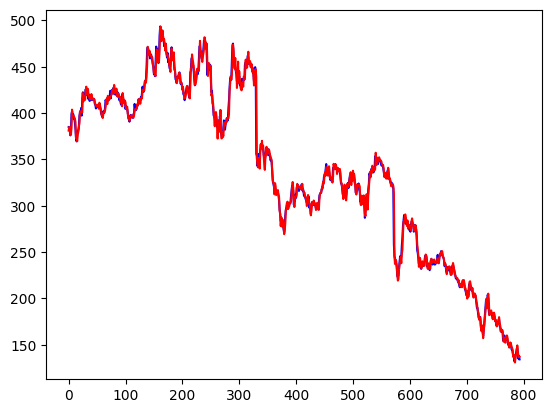

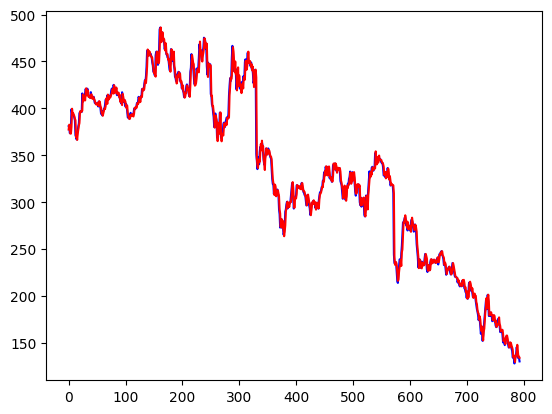

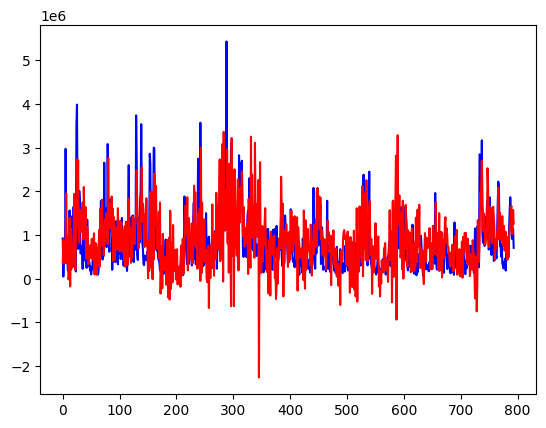

In [22]:
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    plt.plot(Y_test[:,:,i], color="b", label="original")
    plt.plot(predictions[:,:,i], color="r", label="predicted")
    plt.show()

In [23]:
#Считаем метрики по предсказаниям

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    r2 = r2_score(actual, forecast)
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'R^2':r2})

In [24]:
cols = test.columns.to_list()

for vi in range(len(cols)):
    print(f'Forecast Accuracy of: {cols[vi]}')
    n1 = f"{cols[vi]}_forecast"
    accuracy_prod = forecast_accuracy(predictions[:,:,vi], Y_test[:,:,vi])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))
    print('')

Forecast Accuracy of: Open
mape :  0.0062
me :  0.0627
mae :  1.9324
mpe :  0.0004
rmse :  4.3927
R^2 :  0.9977

Forecast Accuracy of: High
mape :  0.0104
me :  0.055
mae :  3.3655
mpe :  0.0005
rmse :  5.5528
R^2 :  0.9964

Forecast Accuracy of: Close
mape :  0.0152
me :  0.1853
mae :  4.6848
mpe :  0.0016
rmse :  7.1262
R^2 :  0.994

Forecast Accuracy of: Volume
mape :  1.2136
me :  101203.7112
mae :  574508.77
mpe :  0.7016
rmse :  768972.4219
R^2 :  -0.3864



In [ ]:
#Метрики предсказаний, в целом, хорошие: mape, me, mpe для всех рядов (кроме последнего) почти < 1.
#R^2 же показал очень хороший результат (для всех, кроме последнего, вообще 0.95+).
#MAE показал результат хуже от 2 до 5(кроме последнего)

In [25]:
test_size=int(len(df) * 0.2)
test_size

813

In [26]:
train_df = df[:-test_size]
test_df = df[-test_size:]

print(train_df.shape)
print(test_df.shape)

(3252, 4)
(813, 4)


In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)

In [28]:
train_df_scaled

array([[0.26975169, 0.25870982, 0.25242281, 0.44147564],
       [0.25733634, 0.26298045, 0.26966419, 0.74496398],
       [0.27990971, 0.26859969, 0.27811584, 0.49140281],
       ...,
       [0.62076749, 0.60908069, 0.61751183, 0.00470155],
       [0.62866817, 0.62407283, 0.62765382, 0.02396894],
       [0.63882619, 0.63358058, 0.63745774, 0.01967681]])

In [29]:
test_df_scaled

array([[0.64221219, 0.62823106, 0.63322064, 0.0046011 ],
       [0.64334086, 0.62935491, 0.63757043, 0.00619923],
       [0.64785553, 0.64059339, 0.63921569, 0.01115953],
       ...,
       [0.09029345, 0.08574961, 0.08564345, 0.01718525],
       [0.08634312, 0.07687121, 0.07676358, 0.01072575],
       [0.07697517, 0.07077995, 0.06432274, 0.00915806]])

In [30]:
#Создаём датасет из данных.
n_past=18
def createXY(dataset, n_past, col_to_forecast = 0):
    dataX = []
    dataY = []
    for i in range(0, len(dataset) - n_past):
            dataX.append(dataset[i:i + n_past, 0:dataset.shape[1]])
            dataY.append(dataset[i + n_past, col_to_forecast])
    return np.array(dataX),np.array(dataY)

In [31]:
X_train, Y_train = createXY(train_df_scaled, n_past, 2)
X_test, Y_test = createXY(test_df_scaled, n_past, 2)

In [ ]:
X_train.shape

(3234, 18, 5)

In [32]:
X_test.shape

(795, 18, 4)

In [35]:
def build_model(optimizer="adam", npas=n_past, icol=4):
    grid_model = Sequential()
    grid_model.add(LSTM(20 + n_past, input_shape=(n_past, icol)))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    return grid_model

grid_model = KerasRegressor(model=build_model,verbose=1, fit__validation_data=(X_test,Y_test))

parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }


grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2,
                            scoring='neg_mean_squared_error')

In [36]:
# обучаем  и ищем новые параметры
grid_search = grid_search.fit(X_train, Y_train)

Epoch 1/8
102/102 [==============================] - 6s 15ms/step - loss: 0.0128 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 2/8
102/102 [==============================] - 1s 10ms/step - loss: 0.0036 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 3/8
102/102 [==============================] - 1s 10ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 4/8
102/102 [==============================] - 1s 10ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 5/8
102/102 [==============================] - 1s 10ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 8.4818e-04 - val_accuracy: 0.0000e+00
Epoch 6/8
102/102 [==============================] - 1s 10ms/step - loss: 0.0019 - accuracy: 0.0000e+00 - val_loss: 8.1300e-04 - val_accuracy: 0.0000e+00
Epoch 7/8
102/102 [==============================] - 1s 12ms/step - loss: 0.0019 - accuracy:

In [37]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 8, 'optimizer': 'Adadelta'}

In [38]:
# заполняем лучшими параметрами
my_model=grid_search.best_estimator_.model
my_model

<function __main__.build_model(optimizer='adam', npas=18, icol=4)>

In [43]:
prediction=grid_search.best_estimator_.predict(X_test)

print(f"prediction {prediction} \n")
print(f"Prediction Shape {prediction.shape}")

50/50 [==============================] - 0s 5ms/step
prediction [0.625198   0.6272895  0.62742716 0.62556404 0.620343   0.6192721
 0.6334368  0.6433364  0.6495086  0.65452594 0.655967   0.65571946
 0.65277064 0.6450436  0.6314483  0.6180007  0.60990566 0.6082931
 0.6074573  0.61025506 0.62161964 0.6347956  0.64510447 0.6553984
 0.66055673 0.67458266 0.6900925  0.6947968  0.6981955  0.7000196
 0.7039439  0.7097993  0.7119257  0.7114382  0.7129373  0.7123933
 0.7084425  0.7082841  0.70415103 0.70058167 0.7006524  0.700718
 0.6984874  0.69675565 0.6971272  0.695962   0.6945139  0.691443
 0.6877703  0.68340486 0.6797635  0.6775718  0.6776794  0.6768964
 0.67735064 0.6786172  0.67882794 0.676556   0.6720002  0.6665684
 0.66147524 0.65787524 0.65749454 0.65838456 0.6584112  0.66285586
 0.67064637 0.6780886  0.68556166 0.692136   0.69582605 0.6964907
 0.6989544  0.69991267 0.70578456 0.7053091  0.7081881  0.71223235
 0.71469826 0.7147107  0.7181399  0.71834844 0.7180257  0.71549577
 0.7166500

In [44]:
pred = prediction.reshape(-1, 1)

prediction_copies_array = np.repeat(pred,4, axis=-1)
prediction_copies_array.shape

(795, 4)

In [45]:
cfs = len(df.columns)

prediction=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction_copies_array),cfs)))[:,0]
prediction

array([370.9627 , 371.88922, 371.95023, 371.12488, 368.81195, 368.33755,
       374.6125 , 378.99802, 381.7323 , 383.955  , 384.59338, 384.48373,
       383.1774 , 379.75433, 373.7316 , 367.7743 , 364.1882 , 363.47385,
       363.10358, 364.343  , 369.3775 , 375.21445, 379.78128, 384.3415 ,
       386.62662, 392.84012, 399.71097, 401.79498, 403.30063, 404.10867,
       405.84714, 408.44107, 409.3831 , 409.1671 , 409.8312 , 409.5902 ,
       407.84003, 407.76984, 405.9389 , 404.35767, 404.389  , 404.41806,
       403.42993, 402.66275, 402.82736, 402.31116, 401.66968, 400.30927,
       398.68225, 396.74835, 395.13522, 394.1643 , 394.21198, 393.8651 ,
       394.06635, 394.6274 , 394.72076, 393.7143 , 391.6961 , 389.2898 ,
       387.03354, 385.43872, 385.27008, 385.66437, 385.67618, 387.64514,
       391.09634, 394.39325, 397.70383, 400.61624, 402.25095, 402.54538,
       403.6368 , 404.0613 , 406.66257, 406.45193, 407.72733, 409.51892,
       410.61133, 410.61685, 412.13596, 412.22836, 

In [46]:
original_copies_array = np.repeat(Y_test.reshape(-1, 1),cfs, axis=-1)
original_copies_array.shape

(795, 4)

In [47]:
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(Y_test),cfs)))[:,0]

In [48]:
print(f"Pred Values-- {prediction}\n\n")
print(f"Original Values-- {original}")

Pred Values-- [370.9627  371.88922 371.95023 371.12488 368.81195 368.33755 374.6125
 378.99802 381.7323  383.955   384.59338 384.48373 383.1774  379.75433
 373.7316  367.7743  364.1882  363.47385 363.10358 364.343   369.3775
 375.21445 379.78128 384.3415  386.62662 392.84012 399.71097 401.79498
 403.30063 404.10867 405.84714 408.44107 409.3831  409.1671  409.8312
 409.5902  407.84003 407.76984 405.9389  404.35767 404.389   404.41806
 403.42993 402.66275 402.82736 402.31116 401.66968 400.30927 398.68225
 396.74835 395.13522 394.1643  394.21198 393.8651  394.06635 394.6274
 394.72076 393.7143  391.6961  389.2898  387.03354 385.43872 385.27008
 385.66437 385.67618 387.64514 391.09634 394.39325 397.70383 400.61624
 402.25095 402.54538 403.6368  404.0613  406.66257 406.45193 407.72733
 409.51892 410.61133 410.61685 412.13596 412.22836 412.0854  410.96463
 411.47598 411.16104 409.6222  408.88153 407.1841  406.3048  404.4501
 403.02914 401.56976 399.28412 397.57227 398.53625 400.21533 400.519

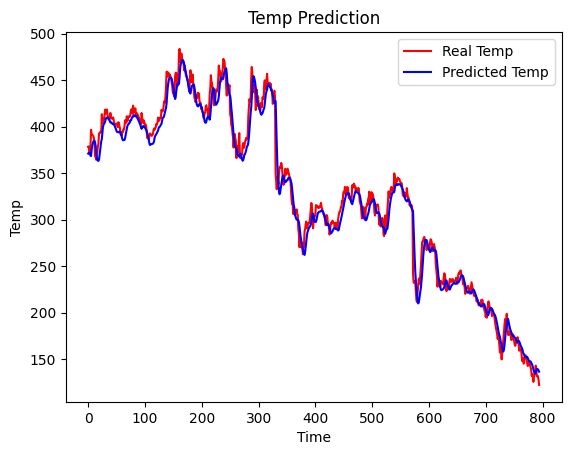

In [49]:
plt.plot(original, color = 'red', label = 'Real Temp')
plt.plot(prediction, color = 'blue', label = 'Predicted Temp')
plt.title('Temp Prediction')
plt.xlabel('Time')
plt.ylabel('Temp')
plt.legend()
plt.show()

In [50]:
print('LSTM metrics:')
metrics = forecast_accuracy(prediction, original)
metric_names = metrics.keys()
for metric in metric_names:
    print(metric, '=', metrics[metric])

LSTM metrics:
mape = 0.028343566680947906
me = -3.6981517487830904
mae = 8.74642393696103
mpe = -0.007832996223209895
rmse = 12.004309026283236
R^2 = 0.9830751054136879


## Заключение
Forecast Accuracy of: High
mape :  0.0104
me :  0.055
mae :  3.3655
mpe :  0.0005
rmse :  5.5528
R^2 :  0.9964

LSTM metrics:
mape = 0.0283
me = -3.6981
mae = 8.7464
mpe = -0.0078
rmse = 12.0043
R^2 = 0.9830
Видно, что классический алгоритм показал лучше результаты, чем нейросеть.

Возможно причиной неудачи нейросети являетя малое количество эпох обучения (8), и для качественной работы нейросети требуется более длительное обучение. Хотя когда искали лучшие параметры, было выбрано меньшее количество эпох. Возможно нужно изменить архитектуру.


Можно сделать вывод, что при отсуствии времении и достаточных вычислительных ресурсов, классические алгоритмы имеют преймущество перед нейросетями. Несмотря на это, мы знаем, что нейросети имеют большую апроксимирующую способность, поэтому при достаточно большом количестве имеющегося времени и вычислительных ресурсов, нейросеть покажет более лучшие результаты, чем класический алгоритм VAR.
